In [1]:
import sys
sys.path.append('..')

from dataloader.ffhq_pbr import FFHQPBR

from torch.utils.data.dataloader import DataLoader
from models.neural_renderer import NeuralRenderer

import torch
import torch.nn as nn
import torchvision.transforms.functional as tvf

from utils.general import hdr2ldr

train_dataset = FFHQPBR(data_path="../dataset/ffhq256_pbr", mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=4, pin_memory=True)

neural_renderer = NeuralRenderer()

input_buffer = next(iter(train_loader))

In [2]:
mask = input_buffer['mask_gt'].reshape(128*128)

albedo = input_buffer['albedo_gt'].reshape(128*128,3)[mask].unsqueeze(1)
roughness = input_buffer['roughness_gt'].reshape(128*128,1)[mask].unsqueeze(1)
specular = input_buffer['specular_gt'].reshape(128*128,1)[mask].unsqueeze(1)
normal = input_buffer['normal_gt'].reshape(128*128,3)[mask].unsqueeze(1)
view_pos = input_buffer['view_pos_gt'].reshape(128*128,3)[mask].unsqueeze(1)
hdri = input_buffer['hdri_gt']

sampled_hdri, sampled_directon = neural_renderer.uniform_sampling(hdri, 2048)

cam_pos = torch.tensor([0., 0., 0.])[None, None, :]
in_dirs = sampled_directon.repeat(view_pos.shape[0],1,1)
out_dirs = (cam_pos - view_pos).broadcast_to(in_dirs.shape)
out_dirs = nn.functional.normalize(out_dirs, dim=-1)

In [14]:
# GGX renderer
def v_schlick_ggx(roughness, cos):
    '''
    Geometry term V, V = G / (4 * cos * cos), schlick ggx
    '''
    r2 = ((1 + roughness) ** 2) / 8
    return 0.5 / (cos * (1 - r2) + r2).clamp(min=1e-2)

def d_sg(roughness, cos):
    r2 = (roughness * roughness).clamp(min=1e-2)
    amp = 1 / (r2 * torch.pi)
    sharp = 2 / r2
    return amp * torch.exp(sharp * (cos - 1))

def pbr_shader(albedo, roughness, specular, normal, out_dirs, in_dirs, hdri):
    
    # Diffuse BRDF
    diffuse_brdf = albedo / torch.pi
    
    # Diffuse BRDF
    half_dirs = in_dirs + out_dirs
    half_dirs = nn.functional.normalize(half_dirs, dim=-1)
    h_d_n = (half_dirs * normal).sum(dim=-1, keepdim=True).clamp(min=0)
    h_d_o = (half_dirs * out_dirs).sum(dim=-1, keepdim=True).clamp(min=0)
    n_d_i = (normal * in_dirs).sum(dim=-1, keepdim=True).clamp(min=0)
    n_d_o = (normal * out_dirs).sum(dim=-1, keepdim=True).clamp(min=0)
    
    # Fresnel term F (Schlick Approximation)
    #F0 = 0.04 * (1 - metallic) + albedo * metallic
    F = specular + (1. - specular) * ((1. - h_d_o) ** 5)
    
    # Geometry term with Smiths Approximation
    V = v_schlick_ggx(roughness, n_d_i) * v_schlick_ggx(roughness, n_d_o)
    
    # Normal distributed function (SG)
    D = d_sg(roughness, h_d_n)
    
    specular_brdf = D * V * F
    
    # RGB color shading
    incident_area = torch.ones_like(hdri) * 2 * torch.pi
    render_output = ((diffuse_brdf + specular_brdf) * hdri * incident_area * n_d_i).mean(dim=1)
    
    return render_output

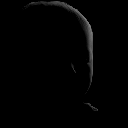

In [24]:
ndi = (normal * in_dirs).sum(dim=-1, keepdim=True).clamp(min=0)
vis_texture = torch.zeros(128*128, 3)
vis_texture[mask] = ndi[:,570,:]
tvf.to_pil_image(vis_texture.reshape(128,128,3).permute(2,0,1))

In [16]:
ggx_result = torch.zeros(128*128, 3)
ggx_result[mask] = pbr_shader(albedo, roughness, specular, normal, out_dirs, in_dirs, sampled_hdri)

In [ ]:
tvf.to_pil_image(input_buffer['albedo_gt'][0].permute(2,0,1))

In [ ]:
tvf.to_pil_image(input_buffer['specular_gt'][0])

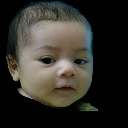

In [8]:
tvf.to_pil_image(input_buffer['rgb_gt'][0].permute(2,0,1))

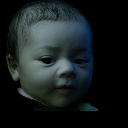

In [17]:
ggx_result_ldr  = hdr2ldr(ggx_result)

tvf.to_pil_image(ggx_result_ldr.reshape(128, 128 ,3).permute(2,0,1))